---
<center><img src="images/RWTH.jpg" width=600></center>

<h1 align="center"> Machine learning approaches for the prediction of oxygen evolution catalysts. </h1> 
<h1 align="center"> Dr. Stefan Palkovits </h1>
<h1 align="center"> <a href="stefan.palkovits@itmc.rwth-aachen.de">stefan.palkovits@itmc.rwth-aachen.de </a> </h1>
<h1 align="center"> <a href="https://twitter.com/palkovitslab?lang=de">@PalkovitsLab</a> </h1>

---

In [8]:
from IPython.display import IFrame

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import altair as alt

%matplotlib inline

In this work we will use several Machine Learning algorithms to predict the overpotential of water oxidation catalysts. The models will be evaluated against each other.

Two datasets will be used:

* J. A. Haber, Y. Cai, S. Jung, C. Xiang, S. Mitrovic, J. Jin, A. T. Bell, J. M. Gregoire, Energy Environ. Sci., 2014, 7, 682–688, DOI: 10.1039/c3ee43683g

* J. A. Haber, C. Xiang, D. Guevarra, S. Jung, J. Jin, J. M. Gregoire, ChemElectroChem 2014, 1, 524 – 528, DOI: 10.1002/celc.201300229

The data from the supplementory information is already compiled for your convenience in a single csv file. 

# Data visualization and preprocessing

First we have to load the data with the help of pandas.

In [2]:
NiFeCoCe_full = pd.read_csv('./data/full_dataset.csv')
NiFeCoCe_own = pd.read_csv('./data/own_dataset.csv')

And we take a look at it with the *head* function.

In [3]:
NiFeCoCe_full.head()

,Ni,Fe,Co,Ce,Overpotential
0,1.000,0.000,0.000,0.0,441.0
1,0.969,0.031,0.000,0.0,426.0
2,0.969,0.000,0.031,0.0,423.0
3,0.929,0.071,0.000,0.0,420.0
4,0.929,0.031,0.031,0.0,422.0


So in the data is just the elemental composition and the measured respective overpotential.

---
## Visualization of the raw data

This time we will mix in some more sophistic visualization tools. Apart from the 'standard' Matplotlib we will use Seaborn for more modern graphics and moreover we will use Altair to have some additional features. Altair differs from Matplotlib and Seaborn as it wants you to specify the graphs in a declarative way to lead the focus on the actual visualization and not on the code for it.

First it is often useful remove the limit in the entries that Altair can deal with. Maybe this is not necessary in later versions.

In [11]:
IFrame(src='https://altair-viz.github.io/', width=900, height=450)

In [7]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

As you see in the next cell Altair works pretty different. We tell Altair

* that we want a chart made from which dataframe,
* how the markers should look like
* and what encodings to use for X and Y.

What we get is a decent looking graph which we can directly save if we want to.

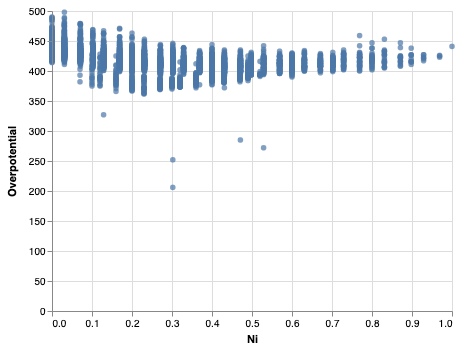

In [5]:
alt.Chart(NiFeCoCe_full).mark_circle().encode(
    alt.X('Ni', type='quantitative'),
    alt.Y('Overpotential', type='quantitative'),
)

If we want some kind of pairplot we have to extend this syntax. We add the rows and columns which we want to repeat and the size of the overall graph. And one power of Altair is the possible interactivity of the graphs which we also add.

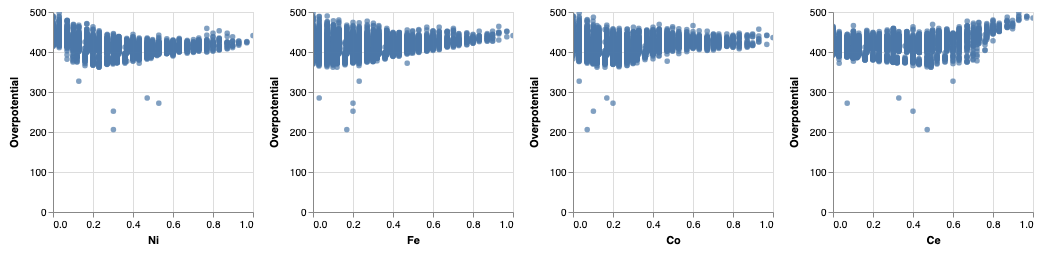

In [7]:
alt.Chart(NiFeCoCe_full).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=200,
    height=200
).repeat(
    row=['Overpotential'],
    column=['Ni', 'Fe', 'Co', 'Ce']
).interactive()

---

## Clustering with k-means algorithm and further visualization with the t-distributed Stochastic Neighbor Embedding (t-SNE) algorithm

To look for structures in the data we will go ahead now with some Unsupervised Learning. Although Principal Component Analysis is often this time it would fail (Try it!). So we will use a combination of

* k-Means Clustering and
* t-distributed stochastic neighbor embedding (t-SNE)

for Unsupervised Learning and visualization.

In [9]:
IFrame(src='https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding', width=900, height=450)

So lets first import the k-MEans algorithm.

In [10]:
from sklearn.cluster import KMeans

And now we do an exploratory elbow curve by initiating a set of k-Means instances in a for loop and fitting it to the dataset. Then we calculated the score to evaluate the performance of each clustering with respect to its size. The resulting plot can be found a little further down together with the results from t-SNE.

In [12]:
k_ellbow = []

for E in range(20):
    E = E+1
    kmeans = KMeans(n_clusters=E)
    kmeans.fit(NiFeCoCe_full.loc[:,'Ni':'Ce'])
    score = kmeans.score(NiFeCoCe_full.loc[:,'Ni':'Ce'])
    k_ellbow.append(score)

And of course we do a final clustering and predict with entry in the dataset belongs to which cluster.

In [13]:
k_cluster = KMeans(n_clusters=10)
k_cluster.fit(NiFeCoCe_full.loc[:,'Ni':'Ce'])
y_k_cluster = k_cluster.predict(NiFeCoCe_full.loc[:,'Ni':'Ce'])

And now we import the t-SNE algorithm.

In [14]:
from sklearn.manifold import TSNE

Again we initiate one instance of the algorithm with the respective hyperparameters. The *n_components* is easy to guess as we want a projection in a xy-plane but especially the perplexity is sometimes hard to figure out in this case 30 works decent.

In [15]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, init='pca')
tsne_result = tsne.fit_transform(NiFeCoCe_full.loc[:,'Ni':'Ce'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6074 samples in 0.010s...
[t-SNE] Computed neighbors for 6074 samples in 0.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6074
[t-SNE] Computed conditional probabilities for sample 2000 / 6074
[t-SNE] Computed conditional probabilities for sample 3000 / 6074
[t-SNE] Computed conditional probabilities for sample 4000 / 6074
[t-SNE] Computed conditional probabilities for sample 5000 / 6074
[t-SNE] Computed conditional probabilities for sample 6000 / 6074
[t-SNE] Computed conditional probabilities for sample 6074 / 6074
[t-SNE] Mean sigma: 0.044124
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.387901
[t-SNE] KL divergence after 1000 iterations: 1.350515


And now we plot everything together. From the elbow plot on the left one sees that 10 seems to be a decent cluster amount. On the right hand side it seems that t-SNE was able to spread the data nice into the plane and using the cluster number for the coloring shows that the 10 cluster do not mix much. Apart from Seaborn here a *GridSpec* from Matplotlib is used to get a nice looking distribution of the plots.

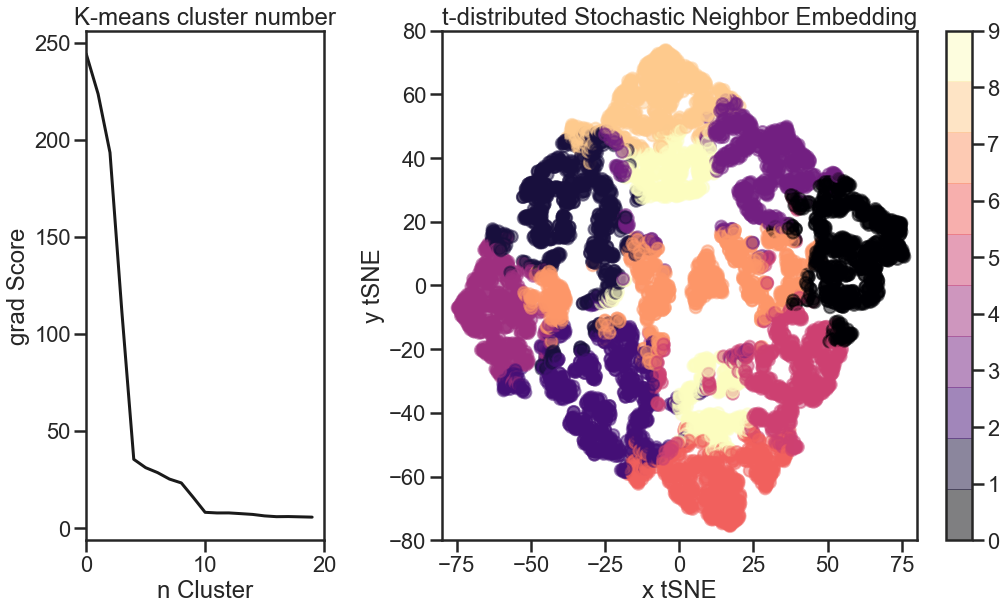

In [19]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(15,9))
grid = plt.GridSpec(1,3)

plt.subplot(grid[0,0])
plt.xlim(0, 20)
plt.title('K-means cluster number')
plt.xlabel('n Cluster')
plt.ylabel('grad Score')
plt.plot(np.gradient(k_ellbow), 'k')

plt.subplot(grid[0,1:])
plt.xlim((-80,80))
plt.ylim((-80,80))
plt.title('t-distributed Stochastic Neighbor Embedding')
plt.xlabel('x tSNE')
plt.ylabel('y tSNE')
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=y_k_cluster, marker='o',alpha=0.5, cmap=plt.cm.get_cmap('magma', 10))
plt.colorbar(ticks=np.arange(0,12))

plt.tight_layout();

In order to not mess up the dataset during the next visualization we now make a copy of the dataset and add the cluster numbers to the dataframe.

In [20]:
Cluster_Visualization = NiFeCoCe_full.copy()
Cluster_Visualization['Cluster'] = pd.Series(y_k_cluster, dtype=str)

As we are in a browser with Jupyter we can to pretty nice visualizations with Altair. The next one is a variation of the pairplot from above. We added not only the clustering information on top of the pairplot as color but we are able to chose the cluster from a drop-down field and while hovering over a datapoint we can see the actual composition as tooltip. This helps us to get the information from the Unsupervised LEarning back to a format that is easier to interpret.

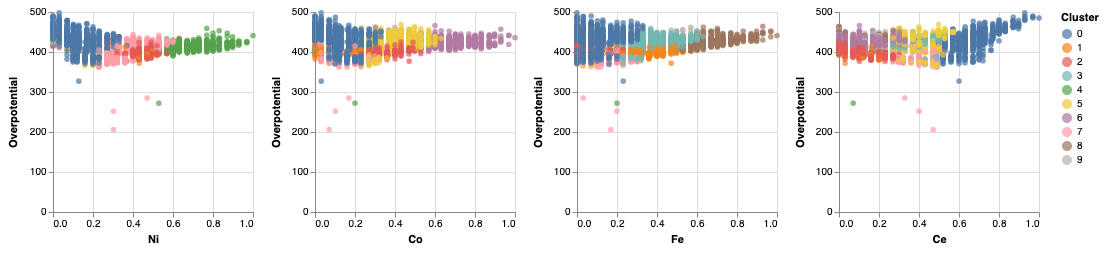

In [21]:
input_dropdown = alt.binding_select(options=['0','1','2', '3', '4', '5', '6', '7', '8'])
selection = alt.selection_single(fields=['Cluster'], bind=input_dropdown, name='Number ')
color = alt.condition(selection,
                    alt.Color('Cluster:N'),
                    alt.value('lightgray'))

chart = alt.Chart(Cluster_Visualization).mark_circle().encode(
    x='Ni',
    y='Overpotential',
    color=color,
    tooltip=['Ni', 'Fe', 'Co', 'Ce']
).properties(
    width=200,
    height=200
).add_selection(
    selection
)

chart | chart.encode(x='Co') | chart.encode(x='Fe') | chart.encode(x='Ce')

---

## Sorting, splitting by overpotential and preprocessing for the Machine Learning algorithms

Before we can go on with Supervised Learning we have to take some care about the splitting of the dataset. When we want to predict the overpotential then it is useful to know that it is desirable for a catalyst to produce an overpotential that is as low as possible. But there are only very few samples with a low overpotential in the dataset. To ensure that the samples with a low overpotential are available in both, the training and the test dataset, we first have to split the dataset and cut the low overpotentials in a separate set. Now it is sure that we have less than 150 samples with a low overpotential.

In [22]:
NiFeCoCe_new = NiFeCoCe_full.sort_values(by=['Overpotential'])

NiFeCoCe_small_OP = NiFeCoCe_new[NiFeCoCe_new['Overpotential']<380]
NiFeCoCe_large_OP = NiFeCoCe_new[NiFeCoCe_new['Overpotential']>=380]

print('Samples with a low overpotential: ', NiFeCoCe_small_OP.shape)
print('Samples with a high overpotential', NiFeCoCe_large_OP.shape)

Samples with a low overpotential:  (146, 5)
Samples with a high overpotential (5928, 5)


Now we do a *train_test_split* of both datasets and add the training and test portions together again. Now we can be sure that the training and test set have the same fraction of low overpotential samples.

In [23]:
from sklearn.model_selection import train_test_split

X1_train, y1_test = train_test_split(NiFeCoCe_large_OP, test_size=0.3, random_state=42)
X2_train, y2_test = train_test_split(NiFeCoCe_small_OP, test_size=0.3, random_state=42)

NiFeCoCe_train = np.vstack((X1_train, X2_train))
NiFeCoCe_test = np.vstack((y1_test, y2_test))

print('Training samples: ', NiFeCoCe_train.shape)
print('Test samples: ', NiFeCoCe_test.shape)

Training samples:  (4251, 5)
Test samples:  (1823, 5)


Now we to a final shuffling of the data.

In [25]:
np.random.seed(42)

order1 = np.argsort(np.random.random(NiFeCoCe_train[:,-1].shape))
order2 = np.argsort(np.random.random(NiFeCoCe_test[:,-1].shape))

NiFeCoCe_train = NiFeCoCe_train[order1]
NiFeCoCe_test = NiFeCoCe_test[order2]

And here we cut the features from the targets and divide the targets by 1000.

In [26]:
train_data = NiFeCoCe_train[:,0:4]
train_label = NiFeCoCe_train[:,-1]/1000

test_data = NiFeCoCe_test[:,0:4]
test_label = NiFeCoCe_test[:,-1]/1000

---

# Artificial Neural Network Approach

<font size="4">

* Neural Networks are state-of-the-art Machine Learning algorithms
* Features mark the inputs
* Targets are the outputs
* The neurons are connected by weights
* Each neuron has an additional activation function


</font>
    
<center><img src="images/network2.png" width=400></center>

In [25]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_squared_error

print('Tensorflow version: ' + tf.__version__)

Tensorflow version: 1.13.1


In [26]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [28]:
neuron_list = np.arange(2, 32, 2)
neuron_error = []

for neuron in neuron_list:
        
    model_opt = keras.Sequential([
        layers.Dense(neuron, activation='relu', input_shape=(train_data.shape[1],)),
        layers.Dense(neuron, activation='relu'),
        layers.Dense(1)
        ])
    
    optimizer = keras.optimizers.RMSprop(lr=0.001)
    
    model_opt.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
        
    model_opt.fit(train_data, train_label, epochs=500, validation_split=0.2, verbose=0, callbacks=[early_stop])
    
    predictions_ann = model_opt.predict(test_data).flatten()
    
    error_ann = np.sqrt(mean_squared_error(test_label,predictions_ann))
        
    neuron_error.append(error_ann)
    
    print('\r', 'Neurons used =', neuron, 'Error =', error_ann, 'Epochs =', model_opt.history.epoch[-1], end='')

print('Done!')

Neurons used = 2 Error = 0.013235632982975669 Epochs = 72
Neurons used = 4 Error = 0.013621366422788793 Epochs = 54
Neurons used = 6 Error = 0.011684503884378066 Epochs = 59
Neurons used = 8 Error = 0.01110200820083654 Epochs = 47
Neurons used = 10 Error = 0.01132558764529436 Epochs = 90
Neurons used = 12 Error = 0.012095741237956837 Epochs = 97
Neurons used = 14 Error = 0.011202858172627454 Epochs = 104
Neurons used = 16 Error = 0.013891368005849091 Epochs = 46
Neurons used = 18 Error = 0.010732911905892272 Epochs = 58
Neurons used = 20 Error = 0.015107766403692909 Epochs = 44
Neurons used = 22 Error = 0.010761151352100538 Epochs = 131
Neurons used = 24 Error = 0.013747345857987859 Epochs = 125
Neurons used = 26 Error = 0.010512343658034096 Epochs = 49
Neurons used = 28 Error = 0.01051663597982559 Epochs = 67
Neurons used = 30 Error = 0.011410781680492485 Epochs = 41
Done!


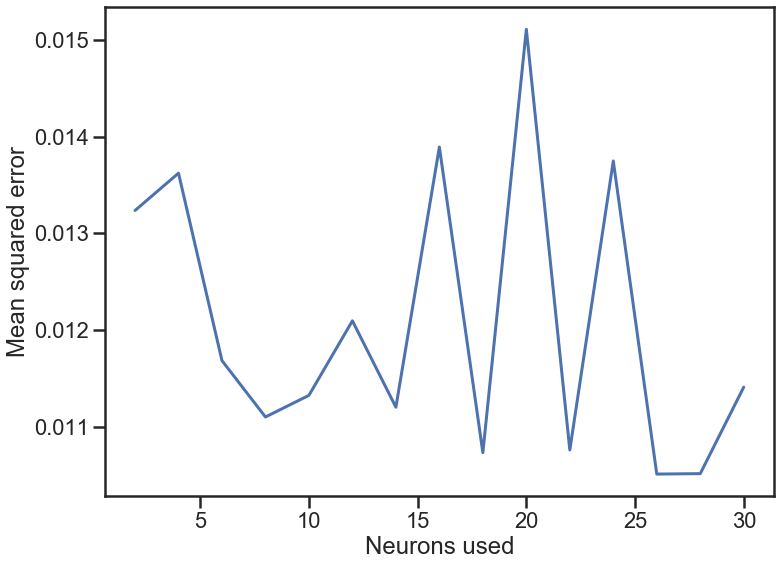

In [31]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(12,9))

plt.xlabel('Neurons used')
plt.ylabel('Mean squared error')
plt.plot(neuron_list, neuron_error);

In [65]:
%%time

model = tf.keras.models.Sequential([
    layers.Dense(6, activation='relu', input_shape=(train_data.shape[1],)),
    layers.Dense(6, activation='relu'),
    layers.Dense(1)
])
    
optimizer = tf.keras.optimizers.RMSprop(lr=0.001)
    
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
model.fit(train_data, train_label, epochs=500, validation_split=0.2, verbose=0, callbacks=[early_stop])

CPU times: user 15.7 s, sys: 2.08 s, total: 17.8 s
Wall time: 12.8 s


In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 6)                 30        
_________________________________________________________________
dense_97 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 7         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


## Metrics of the Artificial Neural Network

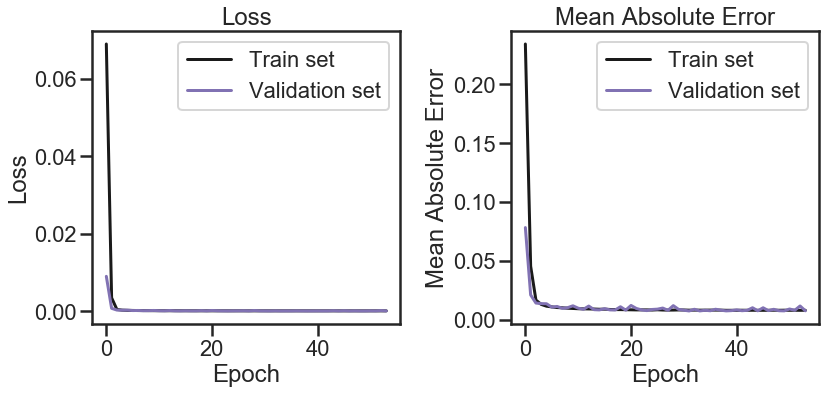

In [34]:
sns.set()
sns.set(style='ticks', context='poster', palette='magma')
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model.history.epoch, np.array(model.history.history['loss']), 'k',label='Train set')
plt.plot(model.history.epoch, np.array(model.history.history['val_loss']), 'm', label='Validation set')
plt.legend()

plt.subplot(122)
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.plot(model.history.epoch, np.array(model.history.history['mean_absolute_error']), 'k', label='Train set')
plt.plot(model.history.epoch, np.array(model.history.history['val_mean_absolute_error']), 'm', label='Validation set')
plt.legend()
         
plt.tight_layout()

In [45]:
train_predictions = model.predict(train_data).flatten()
test_predictions = model.predict(test_data).flatten()

predict_own_data = model.predict(NiFeCoCe_own.loc[:,'Ni':'Ce']).flatten()

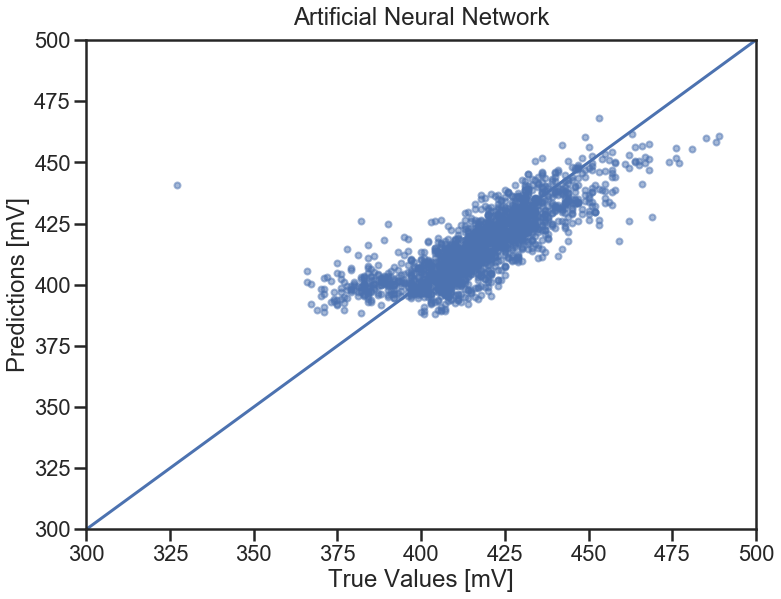

In [55]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(12,9))

plt.xlim((300,500))
plt.ylim((300,500))
plt.title('Artificial Neural Network', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, test_predictions*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000]);

---

# Support vector regression

In [36]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [37]:
%%time
hyper_params = {'gamma':[1, 10, 100],
                'C':[1, 10, 100],
                'epsilon':[0.001, 0.01, 0.1]}

svr_tune = SVR(kernel='rbf')
g_search = RandomizedSearchCV(svr_tune, hyper_params, cv=5, n_jobs=-1)
g_search.fit(train_data, train_label)

CPU times: user 12.3 s, sys: 228 ms, total: 12.5 s
Wall time: 10min 21s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [1, 10, 100],
                                        'epsilon': [0.001, 0.01, 0.1],
                                        'gamma': [1, 10, 100]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [38]:
print('Best Score', g_search.best_score_)
print('Best Estimator ', g_search.best_estimator_)

Best Score 0.7544703519075192
Best Estimator  SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=10,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [39]:
best_C = g_search.best_estimator_.C
best_gamma = g_search.best_estimator_.gamma
best_epsilon = g_search.best_estimator_.epsilon

In [40]:
svr_rbf = SVR(kernel='rbf', C=10, gamma=10, epsilon=0.001)
y_svr = svr_rbf.fit(train_data, train_label)

In [41]:
predict_svr_train = y_svr.predict(train_data)
predict_svr = y_svr.predict(test_data)

predict_own_svr = y_svr.predict(NiFeCoCe_own.loc[:,'Ni':'Ce'])

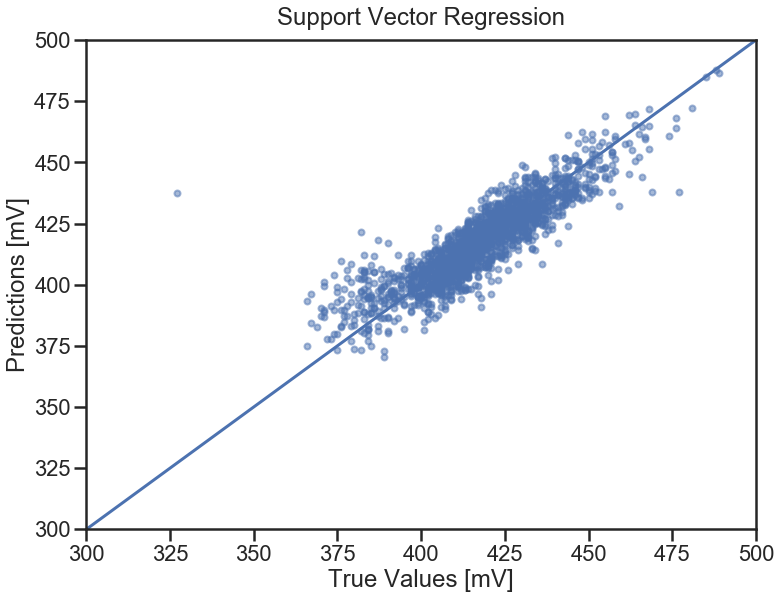

In [56]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(12,9))

plt.xlim((300,500))
plt.ylim((300,500))
plt.title('Support Vector Regression', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, predict_svr*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000]);

---

# k-Nearest Neighbour regression

In [48]:
from sklearn import neighbors

In [49]:
rmse_val = []
for K in range(50):
    K = K+1
    model_knn = neighbors.KNeighborsRegressor(n_neighbors = K)
    model_knn.fit(train_data, train_label)
    predict_knn = model_knn.predict(test_data)
    error = np.sqrt(mean_squared_error(test_label,predict_knn))
    rmse_val.append(error)

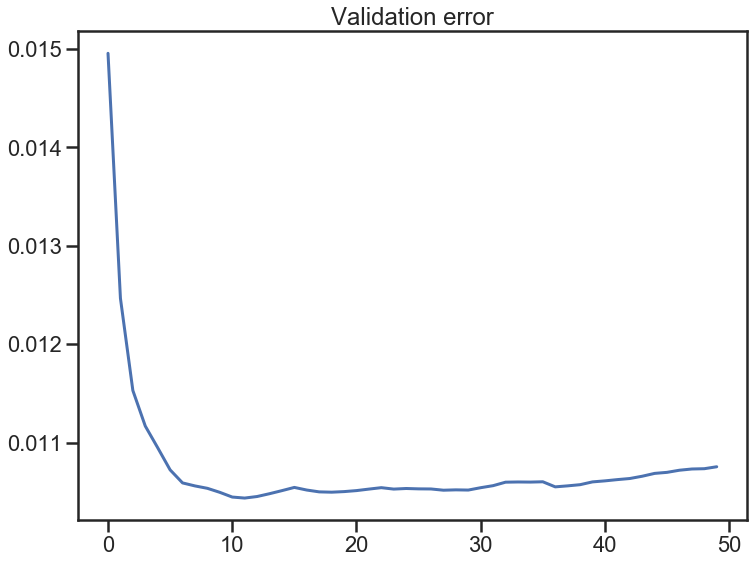

In [57]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(12,9))

plt.title('Validation error')
plt.plot(rmse_val)

In [51]:
print(np.argmin(rmse_val))
best_k = np.argmin(rmse_val)

11


In [52]:
model_knn = neighbors.KNeighborsRegressor(n_neighbors = 11)
model_knn.fit(train_data, train_label)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                    weights='uniform')

In [53]:
predict_knn_train=model_knn.predict(train_data)
predict_knn=model_knn.predict(test_data)

predict_own_knn=model_knn.predict(NiFeCoCe_own.loc[:,'Ni':'Ce'])

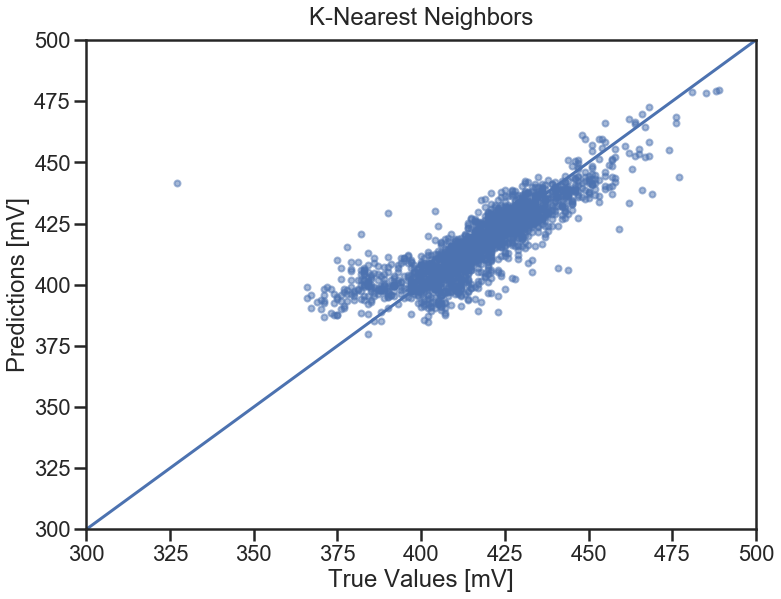

In [60]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(12,9))

plt.xlim((300,500))
plt.ylim((300,500))
plt.title('K-Nearest Neighbors', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, predict_knn*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000]);

---

# Prediction overview

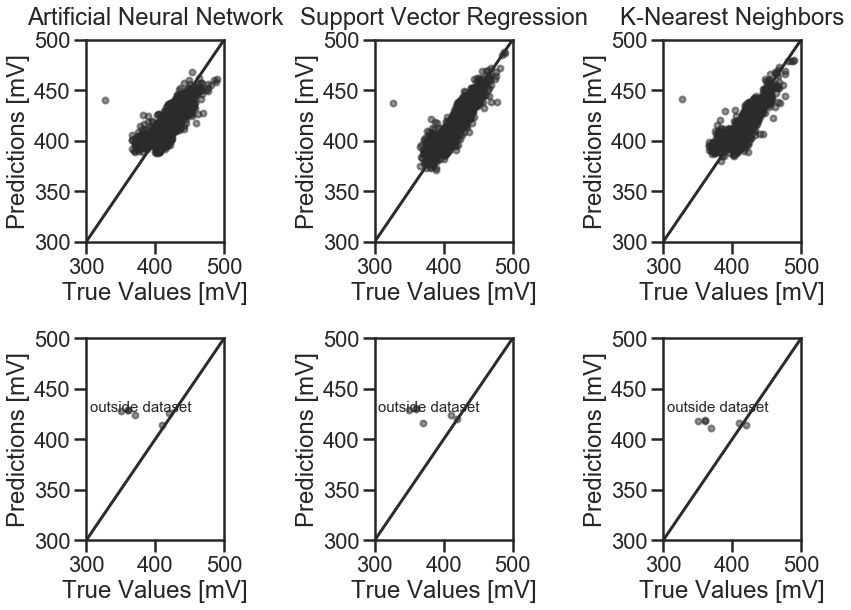

In [61]:
sns.set()
sns.set(style='ticks', context='poster', palette='Greys_r')
plt.figure(figsize=(12,9))

plt.subplot(231)
plt.xlim((300,500))
plt.ylim((300,500))
plt.title('Artificial Neural Network', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, test_predictions*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000])

plt.subplot(232)
plt.xlim((300,500))
plt.ylim((300,500))
plt.title('Support Vector Regression', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, predict_svr*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000])

plt.subplot(233)
plt.xlim((300,500))
plt.ylim((300,500))
plt.title('K-Nearest Neighbors', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, predict_knn*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000])

plt.subplot(234)
plt.xlim((300,500))
plt.ylim((300,500))
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(NiFeCoCe_own.loc[:,'Overpotential'], predict_own_data*1000, marker='.', alpha=0.5)
plt.annotate('outside dataset', xy=(305,428), size=15)
plt.plot([-1000, 1000], [-1000, 1000])

plt.subplot(235)
plt.xlim((300,500))
plt.ylim((300,500))
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(NiFeCoCe_own.loc[:,'Overpotential'], predict_own_svr*1000, marker='.', alpha=0.5)
plt.annotate('outside dataset', xy=(305,428), size=15)
plt.plot([-1000, 1000], [-1000, 1000])

plt.subplot(236)
plt.xlim((300,500))
plt.ylim((300,500))
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(NiFeCoCe_own.loc[:,'Overpotential'], predict_own_knn*1000, marker='.', alpha=0.5)
plt.annotate('outside dataset', xy=(305,428), size=15)
plt.plot([-1000, 1000], [-1000, 1000])

plt.tight_layout()

---

# Calculating overall metrics

In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse_ann = mean_squared_error(test_label,test_predictions)
mse_ann_train = mean_squared_error(train_label,train_predictions)

mse_svr = mean_squared_error(test_label,predict_svr)
mse_svr_train = mean_squared_error(train_label,predict_svr_train)

mse_knn = mean_squared_error(test_label,predict_knn)
mse_knn_train = mean_squared_error(train_label,predict_knn_train)

r2_ann_train = r2_score(train_label,train_predictions)
r2_ann = r2_score(test_label,test_predictions)

r2_svr_train = r2_score(train_label,predict_svr_train)
r2_svr = r2_score(test_label,predict_svr)

r2_knn_train = r2_score(train_label,predict_knn_train)
r2_knn = r2_score(test_label,predict_knn)

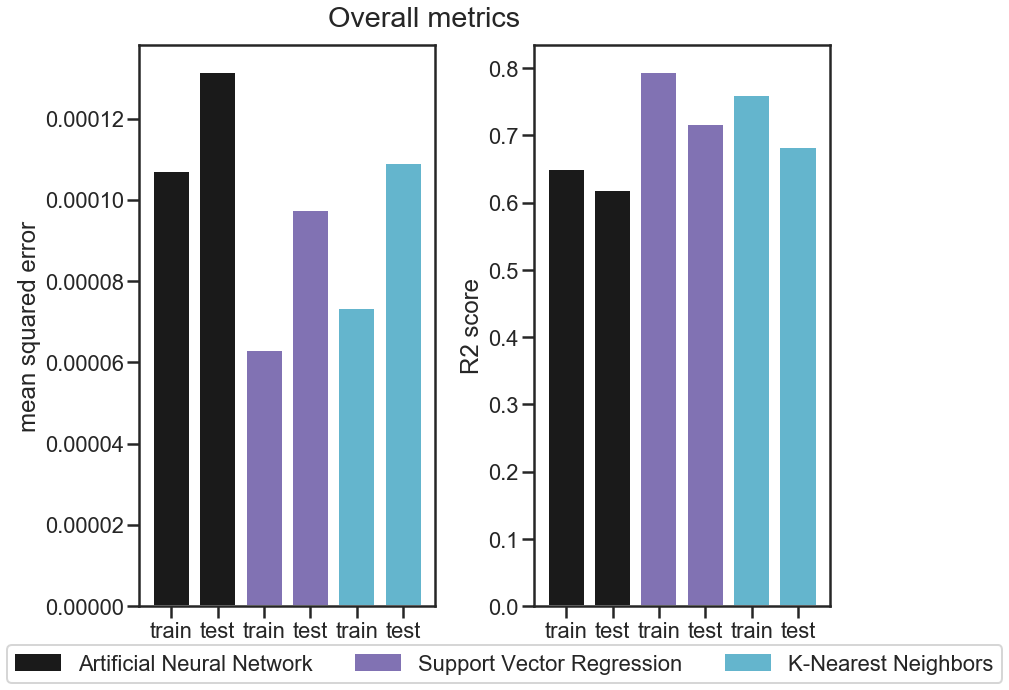

In [63]:
sns.set()
sns.set(style='ticks', context='poster', palette='magma')

ann = mpatches.Patch(color='k', label='Artificial Neural Network')
svr = mpatches.Patch(color='m', label='Support Vector Regression')
knn = mpatches.Patch(color='c', label='K-Nearest Neighbors')

names = ['train', 'test', 'train', 'test', 'train', 'test']
pos = range(len(names))
colors = ['k', 'k', 'm', 'm', 'c', 'c']
rotation = 0

plt.figure(figsize=(12,9))
plt.suptitle('Overall metrics', y=1.02)
plt.subplot(121)
plt.bar(pos, [mse_ann_train, mse_ann, mse_svr_train, mse_svr,mse_knn_train, mse_knn], color=colors)
plt.xticks(pos, names,rotation=rotation)
plt.ylabel('mean squared error')

plt.subplot(122)
plt.bar(pos, [r2_ann_train,r2_ann, r2_svr_train, r2_svr,r2_knn_train, r2_knn], color=colors)
plt.xticks(pos, names, rotation=rotation)
plt.ylabel('R2 score')

plt.tight_layout()
plt.legend(loc='upper center', handles=[ann, svr, knn], ncol=3, bbox_to_anchor=(-0.1, -0.05));

---

# Summary

<font size="4">

* Machine Learning can be used to predict the overpotential of literature datasets and catalysts from our own work

* Simple models like Support Vector Regression are able to outperform more complex Artificial Neural Networks

* Visualization, preprocessing of data and tuning of hyperparameters are important tasks for Machine Learning
    
</font>